In [1]:
%load_ext autoreload

%autoreload 2

In [17]:
from prosit_t.eval import prosit_transformer_eval
import wandb
import tensorflow as tf
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os
from prosit_t.wandb_agent.train_utils import get_proteometools_data
from prosit_t.models import PrositTransformerV2
import pandas as pd
from dlomix.models import PrositIntensityPredictor
import numpy as np
from prosit_t.data.parquet_to_tfdataset_padded_filtered import (
    get_tfdatasets_padded_filtered,
)
from prosit_t.constants import ALPHABET_UNMOD

In [4]:
pio.renderers.default = "iframe"

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [7]:
data_config = {
    "dataset": "proteometools",
    "data_source": {
        "train": "/cmnfs/proj/prosit/Transformer/all_unmod_train.parquet",
        "val": "/cmnfs/proj/prosit/Transformer/all_unmod_test.parquet",
    },
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [8]:
project_name = "transforming-prosit-first-pool"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [9]:
_, val_data = get_tfdatasets_padded_filtered(data_config)

2023-11-30 10:16:38.470327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 10:16:38.624505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e2:00.0, compute capability: 8.6


In [19]:
num_batches = len(val_data)
batch_size = 1024

In [20]:
data_list = prosit_transformer_eval.dataset_to_list(val_data.take(num_batches))
df = pd.DataFrame(data_list)

In [21]:
df = prosit_transformer_eval.process_df(df)

In [18]:
artifact_path = "prosit-compms/transforming-prosit-full-dataset/model-sweet-vortex-24:v29"
transformer = PrositTransformerV2(seq_length=30,embedding_output_dim=64,num_heads=16,
        num_transformers=8, dense_dim_factor=8)
transformer = prosit_transformer_eval.load_model(run,artifact_path,transformer)

wandb:   4 of 4 files downloaded.  
2023-11-30 10:29:52.409720: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-sweet-vortex-24:v29: FAILED_PRECONDITION: artifacts/model-sweet-vortex-24:v29; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [23]:
transformer_loss = prosit_transformer_eval.compute_losses(transformer, val_data, num_batches, batch_size)

2023-11-30 10:33:28.725872: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 45725646848 bandwidth: 696096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-30 10:33:28.817696: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 39ms/step


2023-11-30 10:40:09.305070: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 45725646848 bandwidth: 696096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 1s 1s/step


In [24]:
df["Transformer_Prosit_loss"] = transformer_loss

In [63]:
baseline_path = "prosit-compms/transforming-prosit-first-pool/model-crawly-monster-930:v55"
baseline = PrositIntensityPredictor(seq_length=30,embedding_output_dim=16,
        recurrent_layers_sizes=(256, 512), vocab_dict=ALPHABET_UNMOD)
baseline = prosit_transformer_eval.load_model(run,baseline_path,baseline)

wandb:   4 of 4 files downloaded.  
2023-11-30 18:06:51.884341: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-crawly-monster-930:v55: FAILED_PRECONDITION: artifacts/model-crawly-monster-930:v55; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [74]:
baseline_loss = prosit_transformer_eval.compute_losses(baseline, val_data, num_batches, batch_size)

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


In [68]:
df["Prosit_loss"] = baseline_loss

In [69]:
from prosit_t.eval import prosit_transformer_eval

In [70]:
df["Transformer_Prosit_(Full Dataset)_SA"] = 1 - np.array(transformer_loss)
df["Prosit_(Full Dataset)_SA"] = 1 - np.array(baseline_loss)

In [71]:
violin_sequence_length = prosit_transformer_eval.violin_plot_comparison_per_feature_val(
    df,
    ["Transformer_Prosit_(Full Dataset)_SA", "Prosit_(Full Dataset)_SA"],
    "sequence_length",
    title=None,
    xaxis_title="<b>Sequence Length</b>",
    yaxis_title="<b>Spectral Contrast Angle</b>",
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    plot_bgcolor='rgba(0,0,0,0)',
    width=1000, 
    height=500,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(size=14)
    ),
)
violin_sequence_length.show()

In [52]:
violin_precursor_charge = prosit_transformer_eval.violin_plot_comparison_per_feature_val(
    df,
    ["Transformer_Prosit_(Full Dataset)_SA", "Prosit_(Full Dataset)_SA"],
    "precursor_charge_int",
    title=None,
    xaxis_title="<b>Precursor Charge</b>",
    yaxis_title="<b>Spectral Contrast Angle</b>",
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    plot_bgcolor='rgba(0,0,0,0)',
    width=650, 
    height=500,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(size=14)
    ),
)
violin_precursor_charge.show()

In [56]:
violin_ce_range = prosit_transformer_eval.violin_plot_comparison_per_feature_val(
    df,
    ["Transformer_Prosit_(Full Dataset)_SA", "Prosit_(Full Dataset)_SA"],
    "collision_energy_range",
    title=None,
    xaxis_title="<b>NCE Range</b>",
    yaxis_title="<b>Spectral Contrast Angle</b>",
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    plot_bgcolor='rgba(0,0,0,0)',
    width=650, 
    height=500,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(size=14)
    ),
    xaxis_tickangle=30
)
violin_ce_range.show()

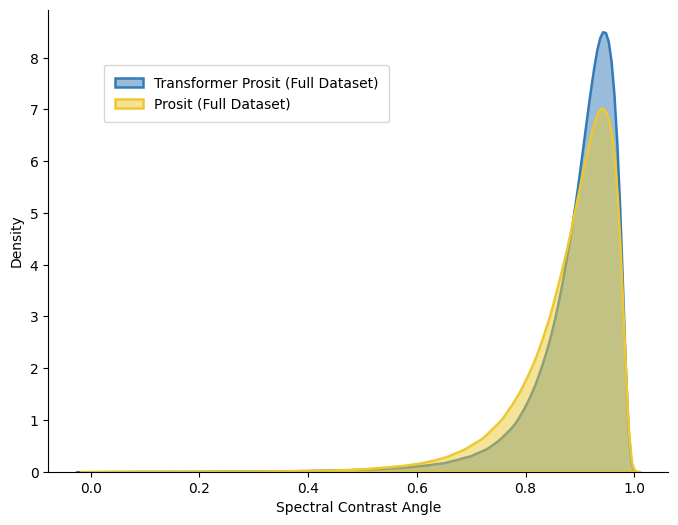

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
prosit_transformer_eval.kde_per_model(
    df,
    ["Transformer_Prosit_(Full Dataset)_SA", "Prosit_(Full Dataset)_SA"],
    title=None,
    xaxis_title="Spectral Contrast Angle",
    yaxis_title="Density",
    colors=["#337ab7", "#edc831", "#ed3131"],
    alpha=0.5,
    fill=True,
    linewidth=1.8,
)
plt.legend(borderpad=0.8, borderaxespad=4.0, loc='upper left')